In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install soynlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 4.8 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import pandas as pd
import ast
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
from collections import defaultdict
from soynlp.tokenizer import RegexTokenizer
from nltk.tokenize import WordPunctTokenizer
import re

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/bitamin_project/output/final_df.csv')

In [ ]:
df.head()

,Unnamed: 0,title,artist,specific_tag,label,number,likes
0,0,! (느낌표),오늘 (Today),"['미세먼지', '스트레스', '황사', '분노', '봄', '먼지', '저리가',...",foggy,2,906
1,1,#93,스키니죠 (Skinnyjoe),"['DJ 지니', '가요', '발라드', '산책', '운동', '거리', '외로움'...",sunrise_sunset,1,45
2,2,#ALL4MYSELF (Feat. YUNHWAY & Tommy Strate & Ji...,Lil Cherry,"['레이블 PICK', '소니뮤직', 'R&B/소울', '하우스파티', '클럽', ...",foggy,1,833
3,3,#Christmas (Vocal 달소영),피아노의 숲,"['오늘의선곡', 'DJ 수수', '가요', '인디', '출/퇴근길', '설렘', ...",snowy,1,67
4,4,#LoveSTAY,Stray Kids (스트레이 키즈),"['노을', '케이팝', '감성', '해질녘', '잔잔한', '휴식', '힐링', ...",sunrise_sunset,1,6674


# 1. 데이터 전처리 (토큰화하기 전 과정)

In [ ]:
text_columns = ['specific_tag', 'label'] # 원래는 tag까지

In [ ]:
text = df[text_columns]

In [ ]:
text.head()

,specific_tag,label
0,"['미세먼지', '스트레스', '황사', '분노', '봄', '먼지', '저리가',...",foggy
1,"['DJ 지니', '가요', '발라드', '산책', '운동', '거리', '외로움'...",sunrise_sunset
2,"['레이블 PICK', '소니뮤직', 'R&B/소울', '하우스파티', '클럽', ...",foggy
3,"['오늘의선곡', 'DJ 수수', '가요', '인디', '출/퇴근길', '설렘', ...",snowy
4,"['노을', '케이팝', '감성', '해질녘', '잔잔한', '휴식', '힐링', ...",sunrise_sunset


In [ ]:
# text의 모든 칼럼들을 1개의 칼럼으로 공백을 기준으로 합쳐줌
# ?) 전체 값들의 토큰을 모델에 입력해야하기 때문에 합쳐줌
text['sentence'] = text[text_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis = 1)

<ipython-input-8-cb9205c73199>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['sentence'] = text[text_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis = 1)


In [ ]:
# 전처리 함수 선언
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [ ]:
# 텍스트 학습전 전처리 적용
sentences=text['sentence'].apply(preprocessing)

In [ ]:
sentences

0          미세먼지    스트레스    황사    분노    봄    먼지    저리가  ...
1          DJ 지니    가요    발라드    산책    운동    거리    외로움 ...
2          레이블 PICK    소니뮤직    R B 소울    하우스파티    클럽   ...
3          오늘의선곡    DJ 수수    가요    인디    출 퇴근길    설렘   ...
4          노을    케이팝    감성    해질녘    잔잔한    휴식    힐링   ...
                               ...                        
40300      시대별음악    DJ 지니        년대    차트         연말 결산...
40301      오늘의선곡    DJ 지니    가요    발라드    댄스    국내음악   ...
40302      DJ 지니    인디    락 메탈    일렉트로니카        년대    가...
40303      스타플레이리스트    스타DJ    JPOP    가요    따뜻한    달콤한...
40304                         TV속음악    DJ 지니    방송   rainy
Name: sentence, Length: 40305, dtype: object

In [ ]:
# 중복되는 줄 제거
sentences.drop_duplicates(inplace = True)

In [ ]:
sentences

0          미세먼지    스트레스    황사    분노    봄    먼지    저리가  ...
1          DJ 지니    가요    발라드    산책    운동    거리    외로움 ...
2          레이블 PICK    소니뮤직    R B 소울    하우스파티    클럽   ...
3          오늘의선곡    DJ 수수    가요    인디    출 퇴근길    설렘   ...
4          노을    케이팝    감성    해질녘    잔잔한    휴식    힐링   ...
                               ...                        
40275                   눈오는날    아이랑    아기랑    좋은노래   snowy
40282      겨울    발라드        년대    추운    눈    눈오는날    사랑...
40283      눈    이별    잔잔한    발라드    마음    겨울    추위    추...
40285      크리스마스    겨울    감성    기분전환    휴식    힐링    따뜻한...
40301      오늘의선곡    DJ 지니    가요    발라드    댄스    국내음악   ...
Name: sentence, Length: 5561, dtype: object

# 2. 'sentences' 데이터 토큰화

In [ ]:
tokenizer = WordPunctTokenizer()
tokenizer

WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)

In [ ]:
tokens = sentences.apply(tokenizer.tokenize)
tokens[:]

0        [미세먼지, 스트레스, 황사, 분노, 봄, 먼지, 저리가, 날려버려, 날씨, 신나는...
1        [DJ, 지니, 가요, 발라드, 산책, 운동, 거리, 외로움, 설렘, 오후, 새벽,...
2        [레이블, PICK, 소니뮤직, R, B, 소울, 하우스파티, 클럽, 밤, 기분전환...
3        [오늘의선곡, DJ, 수수, 가요, 인디, 출, 퇴근길, 설렘, 따뜻한, 편안한, ...
4        [노을, 케이팝, 감성, 해질녘, 잔잔한, 휴식, 힐링, 한강, 아이돌, 저녁, s...
                               ...                        
40275                        [눈오는날, 아이랑, 아기랑, 좋은노래, snowy]
40282    [겨울, 발라드, 년대, 추운, 눈, 눈오는날, 사랑, 이별, 따뜻한, 감성, 기분...
40283    [눈, 이별, 잔잔한, 발라드, 마음, 겨울, 추위, 추억, 눈오는날, 겨울감성, ...
40285    [크리스마스, 겨울, 감성, 기분전환, 휴식, 힐링, 따뜻한, 캐롤, 설렘, 드라이...
40301    [오늘의선곡, DJ, 지니, 가요, 발라드, 댄스, 국내음악, 노래방, 차트, 집,...
Name: sentence, Length: 5561, dtype: object

In [ ]:
len(tokens)

5561

In [ ]:
tokens_reset = tokens.reset_index()

In [ ]:
tokens_reset = tokens_reset['sentence'].tolist()

In [ ]:
no_duplicate = []
for i in range(len(tokens)):
  for j in tokens_reset[i]:
    if j in no_duplicate:
      continue
    else:
      no_duplicate.append(j)

len(no_duplicate)
#len(model.wv.key_to_index)와 같음

1281

# 3. Word2Vec 모델에 학습

In [ ]:
# 로그를 출력하기 위해 불러오기
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO)

In [ ]:
model = word2vec.Word2Vec(tokens, min_count=1, workers = 4)

In [ ]:
len(model.wv.key_to_index)

1281

In [ ]:
model.wv.key_to_index

{'기분전환': 0,
 '휴식': 1,
 '감성': 2,
 '드라이브': 3,
 '잔잔한': 4,
 '카페': 5,
 'DJ': 6,
 '비오는날': 7,
 'snowy': 8,
 '여름': 9,
 'rainy': 10,
 '발라드': 11,
 '여행': 12,
 '겨울': 13,
 'sunny': 14,
 '신나는': 15,
 '흐린날': 16,
 '따뜻한': 17,
 '힐링': 18,
 'sunset': 19,
 'sunrise': 20,
 '크리스마스': 21,
 'foggy': 22,
 '분위기': 23,
 '가요': 24,
 '집': 25,
 '오늘의선곡': 26,
 '편안한': 27,
 '밤': 28,
 '지니': 29,
 'PICK': 30,
 '퇴근길': 31,
 '비': 32,
 '장마': 33,
 '새벽': 34,
 '산책': 35,
 '눈오는날': 36,
 'POP': 37,
 '캐롤': 38,
 '설렘': 39,
 '년대': 40,
 '연말': 41,
 '레이블': 42,
 '팝': 43,
 '저녁': 44,
 '눈': 45,
 '휴가': 46,
 '사랑': 47,
 '인디': 48,
 '추억': 49,
 '위로': 50,
 '댄스': 51,
 '출': 52,
 '오후': 53,
 '맑은날': 54,
 '이별': 55,
 'Pop': 56,
 '봄': 57,
 '노을': 58,
 '국내음악': 59,
 '아침': 60,
 '센치한': 61,
 '시원한': 62,
 '아이돌': 63,
 '매장음악': 64,
 '센치': 65,
 '밝은': 66,
 '여름비': 67,
 '재즈': 68,
 '설레는': 69,
 '차트': 70,
 '더위': 71,
 '운동': 72,
 '미세먼지': 73,
 '가을': 74,
 '행복': 75,
 '팝송': 76,
 '부드러운': 77,
 '소울': 78,
 '주말': 79,
 'R': 80,
 '외로움': 81,
 'B': 82,
 '뉴에이지': 83,
 '공부': 84,
 '빗소리': 85,
 '청량한':

In [ ]:
# Querying the model for top 10 words similar to "sunny"
similar_to_sunny = model.wv.most_similar("sunny", topn=10) if "sunny" in model.wv.key_to_index else "Word not in vocabulary"

similar_to_sunny

[('졸음방지', 0.9773581624031067),
 ('맑은날씨', 0.9481103420257568),
 ('일렉', 0.9404461979866028),
 ('초여름', 0.9321093559265137),
 ('활기찬', 0.9297078847885132),
 ('조깅', 0.9290758967399597),
 ('출근', 0.9252116084098816),
 ('뉴에이지피아노', 0.9224497079849243),
 ('EDM', 0.9207412600517273),
 ('시원', 0.9196712970733643)]

In [ ]:
similar_to_foggy = model.wv.most_similar("foggy", topn=10) if "foggy" in model.wv.key_to_index else "Word not in vocabulary"

similar_to_foggy

[('흐린날', 0.9422922134399414),
 ('몽환적인', 0.9243389368057251),
 ('밤', 0.9167717099189758),
 ('새벽', 0.9033929109573364),
 ('위로', 0.8740591406822205),
 ('비오는날', 0.8708151578903198),
 ('허전함', 0.8609638214111328),
 ('구름가득한날', 0.8592441082000732),
 ('어두운', 0.8542920351028442),
 ('비행기', 0.8421798944473267)]

In [ ]:
similar_to_sunrise = model.wv.most_similar("sunrise", topn=10) if "sunrise" in model.wv.key_to_index else "Word not in vocabulary"

similar_to_sunrise

[('해외알앤비소울', 0.8800469636917114),
 ('글귀', 0.864225447177887),
 ('sunset', 0.8385504484176636),
 ('낙엽', 0.8283072113990784),
 ('수고했어요', 0.8208738565444946),
 ('지하철', 0.8153442144393921),
 ('저녁', 0.8054561018943787),
 ('버스에서', 0.7920511364936829),
 ('해질녘', 0.7819607257843018),
 ('국내RNBSOUL', 0.7808913588523865)]

In [ ]:
similar_to_sunset = model.wv.most_similar("sunset", topn=10) if "sunset" in model.wv.key_to_index else "Word not in vocabulary"

similar_to_sunset

[('sunrise', 0.8385505080223083),
 ('버스에서', 0.8129167556762695),
 ('낙엽', 0.8124889731407166),
 ('해외알앤비소울', 0.7987236976623535),
 ('글귀', 0.797931969165802),
 ('지하철', 0.7918082475662231),
 ('수고했어요', 0.7884901762008667),
 ('저녁', 0.787035346031189),
 ('해질녘', 0.7766813635826111),
 ('국내RNBSOUL', 0.7700712084770203)]

In [ ]:
similar_to_rainy = model.wv.most_similar("rainy", topn=10) if "rainy" in model.wv.key_to_index else "Word not in vocabulary"

similar_to_rainy

[('비내리는날노래', 0.9685634970664978),
 ('비오는밤', 0.9491561651229858),
 ('슬픈', 0.947719931602478),
 ('눈물', 0.9254702925682068),
 ('새벽', 0.9010701179504395),
 ('우울', 0.8954037427902222),
 ('빗소리', 0.8901865482330322),
 ('감성발라드', 0.8887178301811218),
 ('샌치', 0.8879908323287964),
 ('가을비', 0.8856859803199768)]

In [ ]:
similar_to_snowy = model.wv.most_similar("snowy", topn=10) if "snowy" in model.wv.key_to_index else "Word not in vocabulary"

similar_to_snowy

[('크리스마스', 0.9838699102401733),
 ('겨울', 0.9665442705154419),
 ('캐롤', 0.9560622572898865),
 ('눈오는날', 0.9537397623062134),
 ('찬바람', 0.9487136006355286),
 ('추위', 0.9452677369117737),
 ('눈올때', 0.9322209358215332),
 ('싱숭생숭', 0.9317893981933594),
 ('눈오는밤', 0.9248334765434265),
 ('연말', 0.9216034412384033)]

In [ ]:
all_similar_to_sunny = model.wv.most_similar("sunny", topn=1281) if "sunny" in model.wv.key_to_index else []
all_similar_to_foggy = model.wv.most_similar("foggy", topn=1281) if "foggy" in model.wv.key_to_index else []
all_similar_to_rainy = model.wv.most_similar("rainy", topn=1281) if "rainy" in model.wv.key_to_index else []
all_similar_to_snowy = model.wv.most_similar("snowy", topn=1281) if "snowy" in model.wv.key_to_index else []
all_similar_to_sunrise = model.wv.most_similar("sunrise", topn=1281) if "sunrise" in model.wv.key_to_index else []
all_similar_to_sunset = model.wv.most_similar("sunset", topn=1281) if "sunset" in model.wv.key_to_index else []

In [ ]:
def list_to_dictionary(weather_list):
  dictionary = {}
  for i in weather_list:
    key = i[0]
    value = i[1]
    dictionary[key] = value
  return dictionary

In [ ]:
sunny_dict = list_to_dictionary(all_similar_to_sunny)
foggy_dict = list_to_dictionary(all_similar_to_foggy)
rainy_dict = list_to_dictionary(all_similar_to_rainy)
snowy_dict = list_to_dictionary(all_similar_to_snowy)
sunrise_dict = list_to_dictionary(all_similar_to_sunrise)
sunset_dict = list_to_dictionary(all_similar_to_sunset)

In [ ]:
sunrise_dict

In [ ]:
sunrise_sunset_dict = {}
for key, value in sunrise_dict.items():
  if key == 'sunset':
    sunset_value = 1
  else:
    sunset_value = sunset_dict[key]
  avg = (value + sunset_value) / 2
  sunrise_sunset_dict[key] = avg

sunrise_sunset_dict

In [ ]:
len(sunrise_sunset_dict)

1280

In [ ]:
sunrise_sunset_dict['sunset']

0.9350190162658691

In [ ]:
sunset_dict['sunrise']

0.8700379133224487

In [ ]:
#sunrise와 sunset은 하나의 label로 되어 있기 때문에 다시 전처리해서 딕셔너리 합침
#(2개의 값 평균으로 설정. sunrise와 sunset의 경우 본인의 딕셔너리에서 값을 1로 두고 계산)
sunrise_sunset_dict['sunrise'] = (1+sunset_dict['sunrise']) / 2

# 유사도 점수까지 실제 df에 추가하기

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
for i in range(len(df)):
  df['specific_tag'][i] = eval(df['specific_tag'][i])

<ipython-input-34-071f7e4c70d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['specific_tag'][i] = eval(df['specific_tag'][i])


In [ ]:
dictionary_group = {'sunny': sunny_dict, 'foggy': foggy_dict, 'rainy': rainy_dict, \
                    'snowy': snowy_dict, 'sunrise_sunset': sunrise_sunset_dict}

In [ ]:
df.head()

,title,artist,specific_tag,label,number,likes
0,! (느낌표),오늘 (Today),"[미세먼지, 스트레스, 황사, 분노, 봄, 먼지, 저리가, 날려버려, 날씨, 신나는]",foggy,2,906
1,#93,스키니죠 (Skinnyjoe),"[DJ 지니, 가요, 발라드, 산책, 운동, 거리, 외로움, 설렘, 오후, 새벽, ...",sunrise_sunset,1,45
2,#ALL4MYSELF (Feat. YUNHWAY & Tommy Strate & Ji...,Lil Cherry,"[레이블 PICK, 소니뮤직, R&B/소울, 하우스파티, 클럽, 밤, 기분전환, 그...",foggy,1,833
3,#Christmas (Vocal 달소영),피아노의 숲,"[오늘의선곡, DJ 수수, 가요, 인디, 출/퇴근길, 설렘, 따뜻한, 편안한, 겨울...",snowy,1,67
4,#LoveSTAY,Stray Kids (스트레이 키즈),"[노을, 케이팝, 감성, 해질녘, 잔잔한, 휴식, 힐링, 한강, 아이돌, 저녁]",sunrise_sunset,1,6674


In [ ]:
similar = []
for i in range(len(df)):
  label = df['label'][i]
  dictionary = dictionary_group[label]
  small = 0
  for j in df['specific_tag'][i]:
    # 토큰 리스트에 없는 단어 존재. 값을 0으로 지정
    if j not in no_duplicate:
      continue
    else:
      small += dictionary[j]
  # 평균값 구하기
  small = small / len(df['specific_tag'][i])
  similar.append(small)

len(similar)

40305

In [ ]:
similar

[0.4186360202729702,
 0.4171283071239789,
 0.46742569737964207,
 0.3829927384853363,
 0.4478336318396032,
 0.7030964478850364,
 0.46742569737964207,
 0.4951384365558624,
 0.4263506063393184,
 0.3184062625680651,
 0.5983920961618423,
 0.5922161440054575,
 0.593721142411232,
 0.38261262079079944,
 0.12964943051338196,
 0.5129935046037039,
 0.39932883381843565,
 0.3950334280729294,
 0.38661365369334816,
 0.5134420146544775,
 0.531680952012539,
 0.09316204022616148,
 0.6272350370883941,
 0.5134420146544775,
 0.6425308778882026,
 0.4631451931264665,
 0.7679545998573303,
 0.4478336318396032,
 0.4391672020511968,
 0.6795783053551402,
 0.6235140297147963,
 0.15189841389656067,
 0.3123436475172639,
 0.4575157642364502,
 0.4792189337313175,
 0.5118458122014999,
 0.4004108242013238,
 0.7844923615455628,
 0.7635145684083303,
 0.35801267623901367,
 0.6728879332542419,
 0.6290033784779635,
 0.8953301161527634,
 0.23605567107305808,
 0.31187041340903804,
 0.42805655896663664,
 0.4391672020511968,
 0.

In [ ]:
df['similar'] = similar
df.head()

,title,artist,specific_tag,label,number,likes,similar
0,! (느낌표),오늘 (Today),"[미세먼지, 스트레스, 황사, 분노, 봄, 먼지, 저리가, 날려버려, 날씨, 신나는]",foggy,2,906,0.418636
1,#93,스키니죠 (Skinnyjoe),"[DJ 지니, 가요, 발라드, 산책, 운동, 거리, 외로움, 설렘, 오후, 새벽, ...",sunrise_sunset,1,45,0.417128
2,#ALL4MYSELF (Feat. YUNHWAY & Tommy Strate & Ji...,Lil Cherry,"[레이블 PICK, 소니뮤직, R&B/소울, 하우스파티, 클럽, 밤, 기분전환, 그...",foggy,1,833,0.467426
3,#Christmas (Vocal 달소영),피아노의 숲,"[오늘의선곡, DJ 수수, 가요, 인디, 출/퇴근길, 설렘, 따뜻한, 편안한, 겨울...",snowy,1,67,0.382993
4,#LoveSTAY,Stray Kids (스트레이 키즈),"[노을, 케이팝, 감성, 해질녘, 잔잔한, 휴식, 힐링, 한강, 아이돌, 저녁]",sunrise_sunset,1,6674,0.447834


In [ ]:
df.to_csv('/content/drive/MyDrive/bitamin_project/output/df_유사도까지.csv')

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/bitamin_project/output/df_유사도까지.csv')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#sns.distplot(similar, rug=True)
#plt.show()

<ipython-input-5-d0b08a3de0a4>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['number'], rug=True)


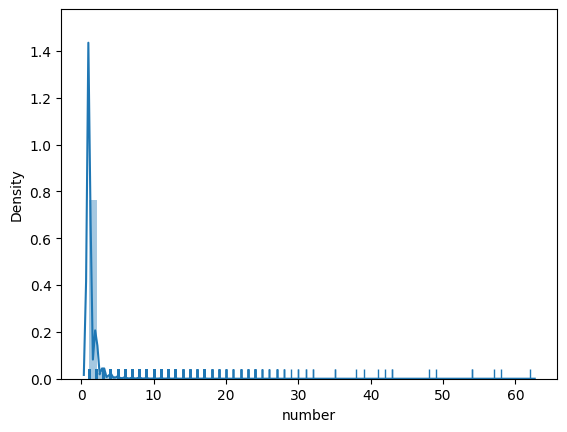

In [ ]:
sns.distplot(df['number'], rug=True)
plt.show()

<ipython-input-15-f00297b412d9>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_data, rug=True)


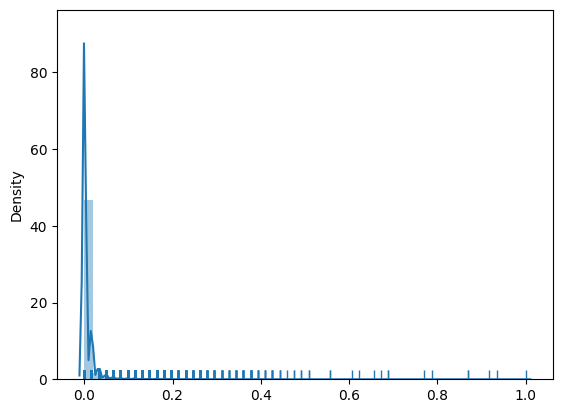

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import numpy as np
transformer = MinMaxScaler()
x_data = df['number'].to_numpy()
#x_data = np.log(x_data)

x_data = x_data.reshape(-1,1)
df['number'] = transformer.fit_transform(x_data)
sns.distplot(x_data, rug=True)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import numpy as np
transformer = MinMaxScaler()
x_data = df['number'].to_numpy()
x_data = x_data.reshape(-1,1)
df['number'] = transformer.fit_transform(x_data)

y_data = df['likes'].to_numpy()
y_data = y_data.reshape(-1,1)
df['likes'] = transformer.fit_transform(y_data)

<ipython-input-42-b8857ed9d2ec>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['likes'], rug=True)


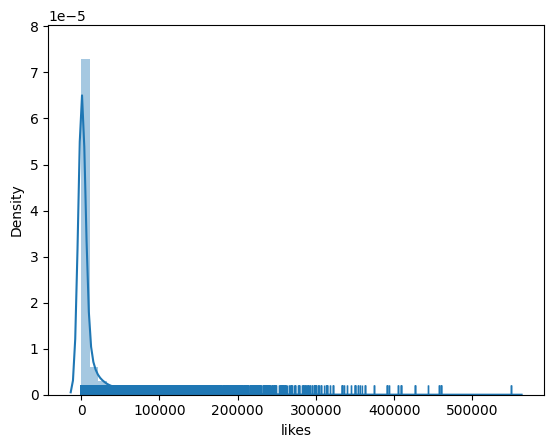

In [ ]:
sns.distplot(df['likes'], rug=True)
plt.show()

In [ ]:
df.head()

,Unnamed: 0,title,artist,specific_tag,label,number,likes,similar
0,0,! (느낌표),오늘 (Today),"['미세먼지', '스트레스', '황사', '분노', '봄', '먼지', '저리가',...",foggy,0.016393,0.001649,0.418636
1,1,#93,스키니죠 (Skinnyjoe),"['DJ 지니', '가요', '발라드', '산책', '운동', '거리', '외로움'...",sunrise_sunset,0.000000,0.000082,0.417128
2,2,#ALL4MYSELF (Feat. YUNHWAY & Tommy Strate & Ji...,Lil Cherry,"['레이블 PICK', '소니뮤직', 'R&B/소울', '하우스파티', '클럽', ...",foggy,0.000000,0.001516,0.467426
3,3,#Christmas (Vocal 달소영),피아노의 숲,"['오늘의선곡', 'DJ 수수', '가요', '인디', '출/퇴근길', '설렘', ...",snowy,0.000000,0.000122,0.382993
4,4,#LoveSTAY,Stray Kids (스트레이 키즈),"['노을', '케이팝', '감성', '해질녘', '잔잔한', '휴식', '힐링', ...",sunrise_sunset,0.000000,0.012144,0.447834


In [ ]:
df['final'] = df['number'] * 4.5 + df['likes'] * 1 + df['similar'] * 4.5
df.head()

,title,artist,specific_tag,label,number,likes,similar,final
0,! (느낌표),오늘 (Today),"['미세먼지', '스트레스', '황사', '분노', '봄', '먼지', '저리가',...",foggy,0.016393,0.001649,0.418636,1.959281
1,#93,스키니죠 (Skinnyjoe),"['DJ 지니', '가요', '발라드', '산책', '운동', '거리', '외로움'...",sunrise_sunset,0.000000,0.000082,0.417128,1.877159
2,#ALL4MYSELF (Feat. YUNHWAY & Tommy Strate & Ji...,Lil Cherry,"['레이블 PICK', '소니뮤직', 'R&B/소울', '하우스파티', '클럽', ...",foggy,0.000000,0.001516,0.467426,2.104931
3,#Christmas (Vocal 달소영),피아노의 숲,"['오늘의선곡', 'DJ 수수', '가요', '인디', '출/퇴근길', '설렘', ...",snowy,0.000000,0.000122,0.382993,1.723589
4,#LoveSTAY,Stray Kids (스트레이 키즈),"['노을', '케이팝', '감성', '해질녘', '잔잔한', '휴식', '힐링', ...",sunrise_sunset,0.000000,0.012144,0.447834,2.027395


In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df[df['label']=='snowy'].sort_values(by='final', ascending=False).head(20)

,title,artist,specific_tag,label,number,likes,similar,final
1080,All I Want for Christmas Is You,Mariah Carey,"['크리스마스', '크리스마스캐롤', '겨울노래', 'pub', '겨울감성', '추...",snowy,0.918033,0.395712,0.663975,7.119454
19451,Snowman,Sia,"['크리스마스', '크리스마스캐롤', '겨울노래', 'pub', '겨울감성', '추...",snowy,0.786885,0.450766,0.651040,6.653232
18377,Santa Tell Me,Ariana Grande,"['크리스마스', '크리스마스캐롤', '겨울노래', 'pub', '겨울감성', '추...",snowy,0.770492,0.422696,0.649329,6.524675
38735,첫 눈,EXO,"['눈오는날', '탑백', 'TOP100', '인기', '차트', '아이돌', '보...",snowy,0.655738,0.383968,0.567234,5.659823
30050,눈 (Feat. 이문세),Zion.T,"['겨울', '눈오는날', '따뜻한', '발라드', '잔잔한', '추억', '추위'...",snowy,0.508197,0.226713,0.605758,4.909244
21264,Text Me Merry Christmas (Feat. Kristen Bell),Straight No Chaser,"['크리스마스', '크리스마스캐롤', '겨울노래', 'pub', '겨울감성', '추...",snowy,0.508197,0.124684,0.650761,4.885199
30155,눈사람,정승환,"['겨울', '눈오는날', '따뜻한', '발라드', '잔잔한', '추억', '추위'...",snowy,0.409836,0.446377,0.573968,4.827970
22889,Underneath The Tree,Kelly Clarkson,"['크리스마스', '크리스마스캐롤', '겨울노래', 'pub', '겨울감성', '추...",snowy,0.475410,0.090335,0.668557,4.756538
13583,Make It To Christmas,Alessia Cara,"['크리스마스', '크리스마스캐롤', '겨울노래', 'pub', '겨울감성', '추...",snowy,0.459016,0.091134,0.666594,4.684707
3107,Bring Me Love,John Legend,"['크리스마스', '크리스마스캐롤', '겨울노래', 'pub', '겨울감성', '추...",snowy,0.491803,0.046629,0.653003,4.672484


In [ ]:
df.groupby('label').count()

,title,artist,specific_tag,number,likes,similar,final
label,,,,,,,
foggy,9433,9433,9433,9433,9433,9433,9433
rainy,8473,8473,8473,8473,8473,8473,8473
snowy,6104,6104,6104,6104,6104,6104,6104
sunny,6906,6906,6906,6906,6906,6906,6906
sunrise_sunset,9389,9389,9389,9389,9389,9389,9389


In [ ]:
def recommend(input):
  df_input = df[df['label']==input]
  df_input.sort_values(by='final', ascending=False, inplace=True)
  df_input = df_input[:len(df_input)//20] # 상위 5% 추출
  output = df_input.sample(n=10, replace=False)

  return output

In [ ]:
df_input = df[df['label']=='sunny']
df_input.sort_values(by='final', ascending=False, inplace=True) #실제로는 similar가 아닌 최종 판단 변수로 진행해야 함
df_input = df_input[:len(df_input)//10] # 상위 20% 추출
df_input.tail()

<ipython-input-36-a0fb7b492665>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.sort_values(by='final', ascending=False, inplace=True) #실제로는 similar가 아닌 최종 판단 변수로 진행해야 함


,title,artist,specific_tag,label,number,likes,similar,final
36192,여행,볼빨간사춘기,"['시원', '맑은날', '산뜻함', '여행', '신나는_음악', '인디음악', '...",sunny,0.278689,0.543501,0.689968,4.961627
32738,봄날,방탄소년단,"['방탄소년단', '최신노래', '맑은날', '월요병', '봄', '사랑', '아이...",sunny,0.016393,1.000000,0.695143,4.846146
33482,빨간 맛 (Red Flavor),Red Velvet (레드벨벳),"['여름', '댄스곡', '여돌', '남돌', '여행', '아이돌', '기분업', ...",sunny,0.213115,0.427662,0.729126,4.624288
31227,롤린 (Rollin'),브레이브걸스,"['방탄소년단', '최신노래', '맑은날', '월요병', '봄', '사랑', '아이...",sunny,0.163934,0.546947,0.704874,4.569129
6137,Dynamite,방탄소년단,"['방탄소년단', '최신노래', '맑은날', '월요병', '봄', '사랑', '아이...",sunny,0.098361,0.832168,0.606964,4.485635
...,...,...,...,...,...,...,...,...
13801,Me Too,Ayanis,"['운동', '스트레스', '다이어트', '신나는', '드라이브', '헬스', '텐...",sunny,0.000000,0.009797,0.786625,3.166094
15243,No Time For Tears,"Nathan Dawe, Little Mix","['여름', '기분전환', '청량한', '시원한', '텐션업', '드라이브', '여...",sunny,0.000000,0.002444,0.790189,3.165644
18069,SAD,Eli,"['드라이브', '기분업업', '여행을', '출근', '퇴근']",sunny,0.000000,0.007335,0.787700,3.165471
12852,Lost,Blake Rose,"['드라이브', '기분업업', '여행을', '출근', '퇴근']",sunny,0.000000,0.007293,0.787700,3.165388


In [ ]:
recommend('sunny')

<ipython-input-48-f7cc9719dead>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.sort_values(by='final', ascending=False, inplace=True)


,title,artist,specific_tag,label,number,likes,similar,final
20695,"Surfin’ (리노, 창빈, 필릭스)",Stray Kids (스트레이 키즈),"['여름에', '듣는', '플레이리스트', '상쾌한노래', '화창한날']",sunny,0.000000,0.028495,0.809697,3.672131
37477,이세상 끝날까지(終天之慕),눈바래기,"['봄', '카페', '화창한날', '뉴에이지', '연주곡', '피아노', '감성'...",sunny,0.360656,0.000040,0.549549,4.095960
9508,How to love,DAY6 (데이식스),"['여름에', '듣는', '플레이리스트', '상쾌한노래', '화창한날']",sunny,0.000000,0.054565,0.809697,3.698200
38748,첫 사랑니 (Rum Pum Pum Pum),f(x),"['맑은', '날씨', '하늘', '파란하늘', '맑은날', '휴일', '주말', ...",sunny,0.000000,0.134127,0.783217,3.658604
35427,"안녕, 여름 (Parade)",Red Velvet (레드벨벳),"['여름에', '듣는', '플레이리스트', '상쾌한노래', '화창한날']",sunny,0.000000,0.033914,0.809697,3.677550
11338,Juice,Lizzo,"['도입부', '기분전환', '피크닉가서듣기좋은', '유니크한', '리드미컬', '...",sunny,0.000000,0.158778,0.798163,3.750512
33968,사랑한다는 말로는(Love word),다소니,"['카페', '피아노', '뉴에이지', '여름', '배경음악', '연주곡', '화창...",sunny,0.360656,0.000013,0.549549,4.095933
38628,참고사항,이무진,"['맑은날', '한낮']",sunny,0.000000,0.039899,0.835549,3.799867
20141,Steal The Show (From “엘리멘탈”),Lauv,"['매장음악', '드라이브', '팝', '카페', '기분전환', '매력적인', '여...",sunny,0.081967,0.219826,0.683118,3.662709
747,AH! LOVE,세븐틴 (SEVENTEEN),"['여름에', '듣는', '플레이리스트', '상쾌한노래', '화창한날']",sunny,0.000000,0.092416,0.809697,3.736052


In [ ]:
recommend('sunny')

<ipython-input-48-f7cc9719dead>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.sort_values(by='final', ascending=False, inplace=True)


,title,artist,specific_tag,label,number,likes,similar,final
2870,Boat,죠지,"['청량한', '해안도로', 'Chill', '신나는', '기분전환', '여행', ...",sunny,0.016393,0.363734,0.747564,3.783299
5832,Don't Start Now,Dua Lipa,"['여행', '드라이브', '여름', '신나는', '기분전환', '청량감', '설렘...",sunny,0.032787,0.299898,0.719171,3.607628
25061,Younger,"Jonas Blue, HRVY","['기분업', '드라이브', '스트레스', '기분전환', '신나는', '조깅', '...",sunny,0.049180,0.049916,0.779165,3.413212
33226,비밀(Secret),피티피노,"['카페', '피아노', '뉴에이지', '여름', '배경음악', '연주곡', '화창...",sunny,0.393443,0.000013,0.538473,3.727689
9584,I (Feat. 버벌진트),태연 (TAEYEON),"['휴가', '여행', '드라이브', '설레는', '연휴', '여름', '기분전환'...",sunny,0.016393,0.408507,0.651428,3.488299
37038,울고 싶지 않아,세븐틴 (SEVENTEEN),"['신나는', '기분전환', '노동요', '드라이브', '초여름', '청량', '운...",sunny,0.000000,0.277693,0.753867,3.570853
13407,MAMACITA,LEON (딥상어),"['드라이브', '맑은날', '맑은날씨', '화창한날씨', '아침', '시작', '...",sunny,0.016393,0.002649,0.830598,3.393264
35400,안녕 (Hello),조이 (JOY),"['DJ베나', '맑은날', '밝게', '신나게', '여름', '드라이브', '신나...",sunny,0.131148,0.243257,0.715862,3.874551
19962,Square (2017),백예린 (Yerin Baek),"['드라이브', '기분전환', '운전', '외출', '여행', '힐링', '상쾌한'...",sunny,0.016393,0.522892,0.632016,3.639422
31429,만세,세븐틴 (SEVENTEEN),"['화창한날', '신나는', 'Mix']",sunny,0.000000,0.187857,0.781432,3.501440
